In [1]:
!pip install -q efficientnet


[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


# Import libraries

In [2]:
import math, re, os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import efficientnet.tfkeras as efn
import tensorflow.keras.layers as L

from sklearn import metrics
from sklearn.model_selection import train_test_split
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

D1019 12:45:46.984097865      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1019 12:45:46.984131628      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1019 12:45:46.984135729      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1019 12:45:46.984138903      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1019 12:45:46.984141776      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1019 12:45:46.984144869      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1019 12:45:46.984147748      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1019 12:45:46.

# Detect TPU for Kaggle

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [4]:
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 10
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/alaska2-image-steganalysis


In [5]:
def create_path(pre):
    return np.vectorize(lambda file: os.path.join(GCS_DS_PATH, pre, file))

In [6]:
submission = pd.read_csv('/kaggle/input/alaska2-image-steganalysis/sample_submission.csv')
train_filenames = np.array(os.listdir("/kaggle/input/alaska2-image-steganalysis/Cover/"))
np.random.seed(0)

In [7]:
one_part = train_filenames.copy()
two_part = train_filenames.copy()
np.random.shuffle(one_part)
np.random.shuffle(two_part)

jmipod = create_path('JMiPOD')(one_part[:10000])
juniward = create_path('JUNIWARD')(one_part[10000:20000])
uerd = create_path('UERD')(one_part[20000:30000])

pos_paths = np.concatenate([jmipod, juniward, uerd])

In [8]:
test_paths = create_path('Test')(submission.Id.values)
cover_paths = create_path('Cover')(two_part[:30000])

In [9]:
train_paths = np.concatenate([pos_paths, cover_paths])
train_labels = np.array([1] * len(pos_paths) + [0] * len(cover_paths))

# Split on train val

In [10]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train_paths, train_labels, test_size=0.15, random_state=2020)

# Decode images for input

In [11]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

# Data loaders

In [12]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

# Callbacks

In [13]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [14]:
scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    min_lr=0.000001
)

In [15]:
with strategy.scope():
    model = tf.keras.Sequential([
        efn.EfficientNetB3(
            input_shape=(512, 512, 3),
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(1, activation='sigmoid')
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=opt,
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

44107200/44107200 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b3 (Functional  (None, 16, 16, 1536)     10783528  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1537      
                                                                 
Total params: 10,785,065
Trainable params: 10,697,769
Non-trainable params: 87,296
_________________________________________________________________


In [16]:
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

history = model.fit(
    train_dataset, 
    epochs=EPOCHS, 
    callbacks=[early, scheduler],
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset
)


Epoch 1/10


2023-10-19 12:47:22.493597: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-19 12:47:23.766997: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


398/398 [==============================] - ETA: 0s - loss: 0.6767 - accuracy: 0.5475

2023-10-19 12:54:38.888797: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-19 12:54:39.192937: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


398/398 [==============================] - 548s 914ms/step - loss: 0.6767 - accuracy: 0.5475 - val_loss: 0.6611 - val_accuracy: 0.5632 - lr: 0.0010
Epoch 2/10
398/398 [==============================] - 296s 744ms/step - loss: 0.6482 - accuracy: 0.5844 - val_loss: 0.6448 - val_accuracy: 0.5863 - lr: 0.0010
Epoch 3/10
398/398 [==============================] - 298s 749ms/step - loss: 0.6328 - accuracy: 0.6029 - val_loss: 0.6667 - val_accuracy: 0.5512 - lr: 0.0010
Epoch 4/10
398/398 [==============================] - 295s 742ms/step - loss: 0.6196 - accuracy: 0.6186 - val_loss: 0.6252 - val_accuracy: 0.6137 - lr: 0.0010
Epoch 5/10
398/398 [==============================] - 295s 741ms/step - loss: 0.6098 - accuracy: 0.6286 - val_loss: 0.6209 - val_accuracy: 0.6093 - lr: 0.0010
Epoch 6/10
398/398 [==============================] - 297s 745ms/step - loss: 0.6028 - accuracy: 0.6362 - val_loss: 0.6210 - val_accuracy: 0.6207 - lr: 0.0010
Epoch 7/10
398/398 [==============================] - ETA

In [17]:
def weighted_auc(y_true, y_valid):
    """ Computation of weighted auc for given task """
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights = [2, 1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_valid, pos_label=1)

    areas = np.array(tpr_thresholds[1:]) - np.array(tpr_thresholds[:-1])
    normalization = np.dot(areas, weights)
    
    competition_metric = 0
    for idx, weight in enumerate(weights):
        y_min = tpr_thresholds[idx]
        y_max = tpr_thresholds[idx + 1]
        mask = (y_min < tpr) & (tpr < y_max)

        x_padding = np.linspace(fpr[mask][-1], 1, 100)

        x = np.concatenate([fpr[mask], x_padding])
        y = np.concatenate([tpr[mask], [y_max] * len(x_padding)])
        y = y - y_min 
        score = metrics.auc(x, y)
        submetric = score * weight
        best_subscore = (y_max - y_min) * weight
        competition_metric += submetric
        
    return competition_metric / normalization

In [19]:
model.save("/kaggle/working/model3.h5")

In [20]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1:
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)

    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.set_title('model '+ title)
    ax.legend(['train', 'valid.'])

/tmp/ipykernel_15/2441444733.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


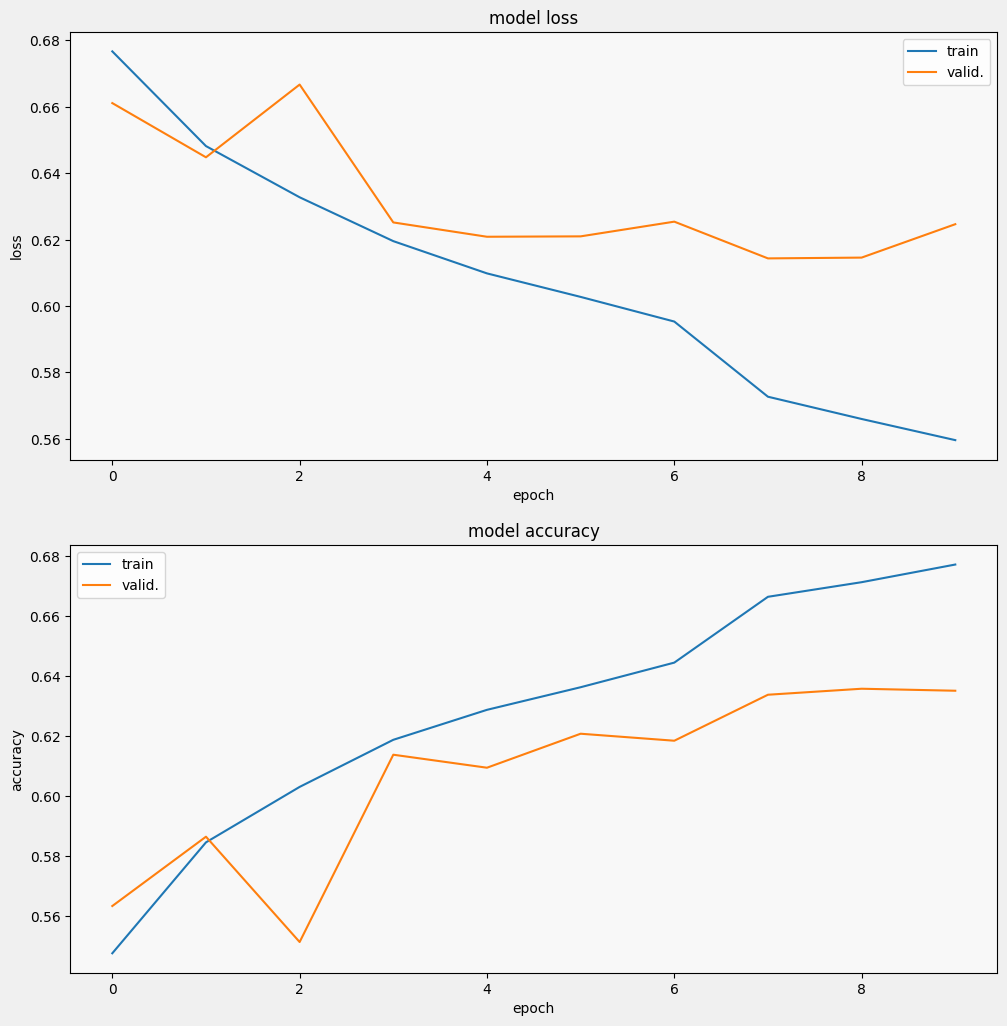

In [21]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss', 211)
display_training_curves(
    history.history['accuracy'], 
    history.history['val_accuracy'], 
    'accuracy', 212)

In [22]:
y_pred=model.predict(valid_dataset)

2023-10-19 13:40:40.077864: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-19 13:40:40.392307: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


71/71 [==============================] - 76s 618ms/step


In [23]:
print(weighted_auc(valid_labels, y_pred))

0.7666515273164443


# Prepare test dataset

In [24]:
jmipod2 = create_path('JMiPOD')(one_part[10000:20000])
juniward2 = create_path('JUNIWARD')(one_part[20000:30000])
uerd2 = create_path('UERD')(one_part[30000:40000])

positives2 = train_filenames.copy()
negatives2 = train_filenames.copy()
np.random.shuffle(positives2)
np.random.shuffle(negatives2)
pos_paths2 = np.concatenate([jmipod2, juniward2, uerd2])

neg_paths2 = create_path('Cover')(negatives2[30000:60000])
train_paths2 = np.concatenate([pos_paths2, neg_paths2])
train_labels2 = np.array([1] * len(pos_paths2) + [0] * len(neg_paths2))
train_paths2, test_paths, train_labels2, test_labels = train_test_split(
    train_paths2, train_labels2, test_size=0.15, random_state=2020)

In [25]:
test_dataset2 = (
    tf.data.Dataset
    .from_tensor_slices((test_paths, test_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [26]:
y_pred=model.predict(test_dataset2)

71/71 [==============================] - 29s 391ms/step


In [27]:
print(weighted_auc(test_labels, y_pred))

0.7869264273438181
